In [1]:
!python --version


Python 3.10.8


In [2]:
!pip install pandas numpy opencv-python matplotlib scikit-learn tensorflow



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

IMAGE_SIZE = 224
DATA_DIR = r'C:\Users\Hp\OneDrive\Documents\Diabetic Retinopathy Detection\aptos2019-blindness-detection\train_images'
LABELS = pd.read_csv(r'C:\Users\Hp\OneDrive\Documents\Diabetic Retinopathy Detection\aptos2019-blindness-detection\train.csv')

def preprocess_image(image_path, size=IMAGE_SIZE):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading: {image_path}")
        return None
    img = cv2.resize(img, (size, size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    return img

def load_dataset():
    images = []
    labels = []
    for i, row in LABELS.iterrows():
        image_file = os.path.join(DATA_DIR, row['id_code'] + '.png')
        if os.path.exists(image_file):
            img = preprocess_image(image_file)
            if img is not None:
                images.append(img)
                labels.append(row['diagnosis'])
    return np.array(images), to_categorical(np.array(labels), num_classes=5)

X, y = load_dataset()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
import os
print(os.getcwd())

C:\Users\Hp\OneDrive\Documents\Diabetic Retinopathy Detection


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    x = base_model(include_top=False, input_tensor=inputs, weights='imagenet')
    x = GlobalAveragePooling2D()(x.output)
    x = Dropout(0.3)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Now build the model
model = build_model(EfficientNetB0)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMAGE_SIZE = 224   # try 128 if memory is still tight
BATCH_SIZE = 8     # increase if it fits later
NUM_CLASSES = 5

csv_path   = r"C:\Users\Hp\OneDrive\Documents\Diabetic Retinopathy Detection\aptos2019-blindness-detection\train.csv"
images_dir = r"C:\Users\Hp\OneDrive\Documents\Diabetic Retinopathy Detection\aptos2019-blindness-detection\train_images"


df = pd.read_csv(csv_path)

# if your columns are different, adjust here:
assert {'id_code', 'diagnosis'}.issubset(df.columns), df.columns

# build absolute file paths
df['filepath'] = images_dir + "\\" + df['id_code'].astype(str) + ".png"
df = df[df['filepath'].map(tf.io.gfile.exists)]   # drop missing files

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['diagnosis'], random_state=42
)

def load_img_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

# optional simple aug
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
])

def make_ds(paths, labels, training):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(len(paths)) if training else ds
    ds = ds.map(load_img_label, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (augment(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_df['filepath'].values, train_df['diagnosis'].values, training=True)
val_ds   = make_ds(val_df['filepath'].values,   val_df['diagnosis'].values,   training=False)

# Example model (swap in your EfficientNet/DenseNet base)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base   = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, epochs=15, validation_data=val_ds)


Epoch 1/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.6472 - loss: 0.9133 - val_accuracy: 0.4925 - val_loss: 1.3765
Epoch 2/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.7487 - loss: 0.6848 - val_accuracy: 0.4598 - val_loss: 1.3648
Epoch 3/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.7734 - loss: 0.6131 - val_accuracy: 0.4925 - val_loss: 2.7971
Epoch 4/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.7920 - loss: 0.5580 - val_accuracy: 0.4925 - val_loss: 2.4269
Epoch 5/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.8132 - loss: 0.5168 - val_accuracy: 0.4925 - val_loss: 24.8602
Epoch 6/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.8059 - loss: 0.4946 - val_accuracy: 0.4925 - val_loss: 10.1318
Epoch 7/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.8178 - loss: 0.4880 - val_accuracy: 0.4925 - val_loss: 91.6623
Epoch 8/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.8176 - loss: 0.4531 - val_a

C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_244']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


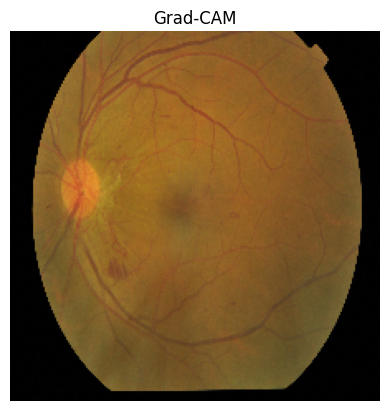

In [10]:
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cm.jet(heatmap)[:, :, :3]
    superimposed_img = heatmap * alpha + img
    return np.uint8(255 * superimposed_img)

# Test on one image
test_img = X_val[0]
heatmap = make_gradcam_heatmap(test_img, model, 'top_conv')
overlay = overlay_heatmap(test_img, heatmap)

plt.imshow(overlay)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


In [11]:
!pip install shap


[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_img_array(img):
    # Assumes img shape is (224, 224, 3) and normalized
    return np.expand_dims(img, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, image, alpha=0.4, cmap='jet'):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = plt.get_cmap(cmap)(heatmap)
    heatmap_colored = np.uint8(255 * heatmap_colored[:, :, :3])
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_img


In [13]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred))


23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       361
           1       0.00      0.00      0.00        74
           2       0.00      0.00      0.00       200
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        59

    accuracy                           0.49       733
   macro avg       0.10      0.20      0.13       733
weighted avg       0.24      0.49      0.33       733



C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [14]:
from tensorflow.keras.applications import DenseNet121

In [15]:
# Existing EfficientNetB0 model
model = build_model(EfficientNetB0)
model.summary()

# 👇 NEW: DenseNet121 model
model_densenet = build_model(DenseNet121)
model_densenet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 224, 224, 3)       │               7 │ rescaling_4[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_5 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer_4[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [16]:
train_ds = make_ds(train_df['filepath'].values, train_df['diagnosis'].values, training=True)
val_ds   = make_ds(val_df['filepath'].values,   val_df['diagnosis'].values,   training=False)


In [17]:
history_densenet = model_densenet.fit(train_ds, epochs=15, validation_data=val_ds)


Epoch 1/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1464s 4s/step - accuracy: 0.6333 - loss: 0.9865 - val_accuracy: 0.7517 - val_loss: 0.6902
Epoch 2/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1300s 4s/step - accuracy: 0.7802 - loss: 0.6139 - val_accuracy: 0.8131 - val_loss: 0.5352
Epoch 3/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1116s 3s/step - accuracy: 0.8061 - loss: 0.5213 - val_accuracy: 0.7885 - val_loss: 0.5368
Epoch 4/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - accuracy: 0.8237 - loss: 0.4723 - val_accuracy: 0.8172 - val_loss: 0.5792
Epoch 5/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1100s 3s/step - accuracy: 0.8521 - loss: 0.4024 - val_accuracy: 0.8145 - val_loss: 0.5608
Epoch 6/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1101s 3s/step - accuracy: 0.8701 - loss: 0.3742 - val_accuracy: 0.7995 - val_loss: 0.6038
Epoch 7/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1105s 3s/step - accuracy: 0.8644 - loss: 0.3734 - val_accuracy: 0.8104 - val_loss: 0.5449
Epoch 8/15
367/367 ━━━━━━━━━━━━━━━━━━━━ 1101s 3s/step - accuracy: 0.8755 - loss: 0.3378 - 

In [18]:
from tensorflow.keras.applications import DenseNet121

model_densenet = build_model(DenseNet121)
model_densenet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 230, 230, 3)       │               0 │ input_layer_5[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_3              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_3[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [19]:
import numpy as np
from sklearn.metrics import classification_report

# predictions
y_pred_densenet = np.argmax(model_densenet.predict(val_ds), axis=1)

# true labels (collect from val_ds)
y_true = np.concatenate([y.numpy() for _, y in val_ds])
y_true = np.argmax(y_true, axis=1)

print("Classification Report: DenseNet121")
print(classification_report(y_true, y_pred_densenet))


92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 748ms/step
Classification Report: DenseNet121
              precision    recall  f1-score   support

           0       0.21      0.09      0.13       361
           1       0.08      0.41      0.13        74
           2       0.00      0.00      0.00       200
           3       0.07      0.38      0.13        39
           4       0.00      0.00      0.00        59

    accuracy                           0.11       733
   macro avg       0.07      0.18      0.08       733
weighted avg       0.12      0.11      0.08       733



C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod